In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from plot_utils import cblind_cmap
from matplotlib.colors import ListedColormap, BoundaryNorm, LogNorm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

plt.style.use("style.mplstyle")

In [4]:
filepath = Path("../preprocessing/data/raw/nsathermocldphaseC1.c1/nsathermocldphaseC1.c1.20210815.000000.nc")
ds = xr.open_dataset(filepath)
ds = ds.sel(height=slice(0, 10))
ds

<xarray.Dataset>
Dimensions:                            (time: 2880, bound: 2, height: 329,
                                        layer: 10)
Coordinates:
  * time                               (time) datetime64[ns] 2021-08-15 ... 2...
  * height                             (height) float32 0.16 0.19 ... 9.97 10.0
  * layer                              (layer) int32 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: bound
Data variables: (12/47)
    base_time                          datetime64[ns] ...
    time_offset                        (time) datetime64[ns] ...
    time_bounds                        (time, bound) datetime64[ns] ...
    cloud_flag                         (time, height) float64 ...
    cloud_phase_hsrl                   (time, height) float64 ...
    qc_cloud_phase_hsrl                (time, height) int32 ...
    ...                                 ...
    mwrret1liljclou_be_pwv             (time) float32 ...
    mwrret1liljclou_tbsky23            (time) float32 ...
    mwrret1liljclou_tbsky31            (time) float32 ...
    lat                                float32 ...
    lon                                float32 ...
    alt                                float32 ...
Attributes: (12/57)
    command_line:                                      thermocldphase -s nsa ...
    Conventions:                                       ARM-1.3
    process_version:                                   vap-thermocldphase-0.3...
    dod_version:                                       thermocldphase-c1-1.3
    input_datastreams:                                 nsa30smplcmask1zwangC1...
    site_id:                                           nsa
    ...                                                ...
    hsrl_weak_backscatter_threshold_comment:           Backscatter threshold ...
    top_backscatter_grad_threshold:                    10.0
    top_backscatter_grad_threshold_comment:            Threshold of backscatt...
    base_backscatter_grad_threshold:                   1.0
    base_backscatter_grad_threshold_comment:           Threshold of backscatt...
    history:                                           created by user levin ...

In [5]:
mpl_dep = ds['mpl_linear_depol_ratio'].data
mpl_dep_snr = ds['mpl_linear_depol_snr'].data
mpl_backscat_snr = ds['mpl_backscatter_snr'].data
mpl_backscat = ds['mpl_backscatter'].data * \
(ds['height'].data**2)
mpl_backscat[mpl_backscat <= 0] = np.nan
mpl_backscat[mpl_backscat_snr <= 0.4] = np.nan
mpl_dep[mpl_dep_snr <= 2] = np.nan

In [6]:
gs = gridspec.GridSpec(nrows=7, ncols=1, height_ratios=[1] * 7, hspace=0.12)
fig = plt.figure(figsize=(6, 8))

# Create subplots
axes = [fig.add_subplot(gs[i, 0]) for i in range(7)]

cmap = "viridis"
ylabel = "Height (km)"

time = ds["time"]
height = ds["height"]
cbar_pad = 0.01
labelpad = 4
cbar_aspect = 5

extent = [
    time.values.min(),
    time.values.max(),
    height.values.min(),
    height.values.max(),
]

i, var_name, label = 0, "mpl_backscatter", r"MPL $\beta$"  # r"$MPL\, \beta$"
im = axes[i].imshow(
    # ds[var_name].T,
    mpl_backscat.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    norm=LogNorm(vmin=1e-2, vmax=1e2),
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 1, "mpl_linear_depol_ratio", "MPL Dep"
im = axes[i].imshow(
    # ds[var_name].T,
    mpl_dep.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=0,
    vmax=0.3,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 2, "reflectivity", "$Z_e$ (dBZ)"  # r"$Z_e\, (dBZ)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=-40,
    vmax=10,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 3, "mean_doppler_velocity", "MDV (m/s)"  # r"$MDV\, (m/s)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=-3,
    vmax=1,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 4, "spectral_width", "W (m/s)"  # r"$W\, (m/s)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=0.0,
    vmax=0.5,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = (
    5,
    "mwrret1liljclou_be_lwp",
    "LWP (g/$m^2$)",
)  # r"$LWP\, (g/m^2)$"
axes[i].plot(ds[var_name], color="black")
axes[i].set_ylabel(label)
# Add a dummy colorbar to maintain alignment for LWP
dummy = plt.cm.ScalarMappable(cmap=cmap)
dummy.set_array([])
cbar = fig.colorbar(dummy, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.ax.remove()


# CLOUD PHASE AND ISOTHERMAL LINES
i, var_name, label = -1, "cloud_phase_mplgr", ""
phases = list(cblind_cmap.keys())[:-1]
phase_labels = {
    "clear": "clear",
    "liquid": "liquid", 
    "ice": "ice", 
    "mixed": "mixed", 
    "drizzle": "drizzle", 
    "liq_driz": "liq_driz", 
    "rain": "rain", 
    "snow": "snow",
    # "avg": "Avg",
}
cmap = ListedColormap(list(cblind_cmap.values())[:-1])
norm = BoundaryNorm(np.arange(-0.5, len(phases) + 0.5), cmap.N)
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    extent=extent,
    origin="lower",
    cmap=cmap,
    norm=norm,
)
cbar = fig.colorbar(
    im,
    ax=axes[i],
    ticks=np.arange(0, len(phases)),
    pad=cbar_pad,
    aspect=cbar_aspect,
)
cbar.set_label(label)
cbar.set_ticks(list(range(len(phases))), labels=[phase_labels[p] for p in phases])
cbar.ax.tick_params(size=0, which="both")
contours = ds["temp"].plot.contour(
    ax=axes[i],
    x="time",
    vmin=-50,
    vmax=10,
    levels=7,
    colors=["black"],
    linestyles="dotted",
    linewidths=0.7,
)
axes[i].clabel(contours, fontsize=5, fmt=lambda x: f"{x:.0f}°C")


letters = ("(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)")
for i in range(len(axes)):
    if i != 5:
        axes[i].set_ylabel(ylabel)
        axes[i].set_yticks(list(range(1,11,2)))#, [""]*10)
    if i != 6:
        axes[i].set_xticks([])
        axes[i].set_xticklabels([])
    axes[i].text(
        x=0.02,
        y=0.9,
        s=letters[i],
        transform=axes[i].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        # fontweight="bold",
        fontsize=9,
    )

axes[-1].set_xlabel(r"Time (UTC)")
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

fig.savefig("figures/overview.png")

plt.close(fig)

/var/folders/5n/ycnfz3351hj0gy28x0pbgbhr0000gn/T/ipykernel_91572/1428104663.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


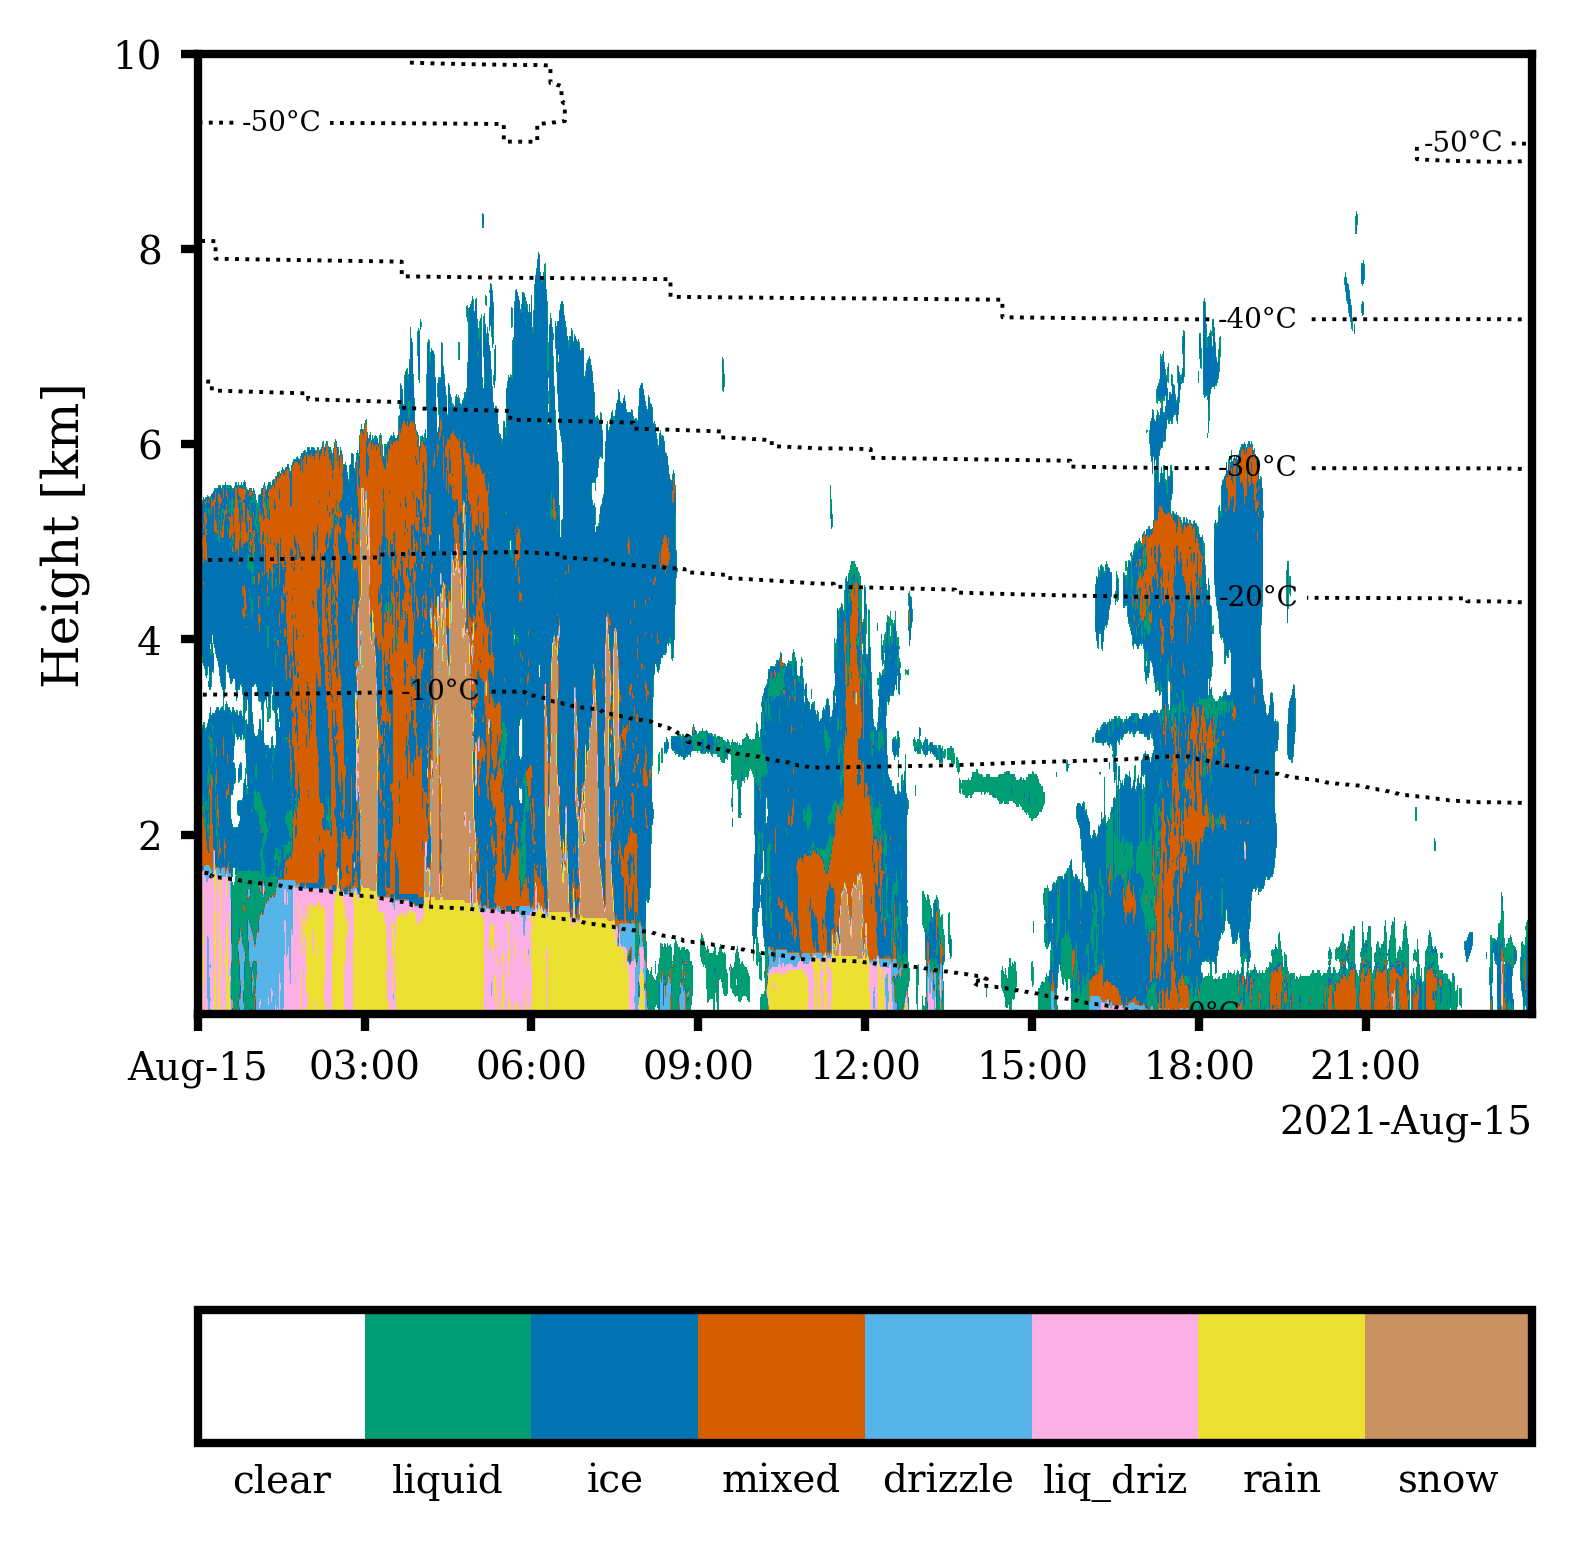

In [ ]:
# OPEN ANX FILE
filepath = Path("../preprocessing/data/raw/nsathermocldphaseC1.c1/nsathermocldphaseC1.c1.20210815.000000.nc")
ds = xr.open_dataset(filepath)
ds = ds.sel(height=slice(0, 10))

In [ ]:
mpl_dep = ds['mpl_linear_depol_ratio'].data
mpl_dep_snr = ds['mpl_linear_depol_snr'].data
mpl_backscat_snr = ds['mpl_backscatter_snr'].data
mpl_backscat = ds['mpl_backscatter'].data * \
(ds['height'].data**2)
mpl_backscat[mpl_backscat <= 0] = np.nan
mpl_backscat[mpl_backscat_snr <= 0.4] = np.nan
mpl_dep[mpl_dep_snr <= 2] = np.nan

In [ ]:
gs = gridspec.GridSpec(nrows=7, ncols=1, height_ratios=[1] * 7, hspace=0.12)
fig = plt.figure(figsize=(6, 8))

# Create subplots
axes = [fig.add_subplot(gs[i, 0]) for i in range(7)]

cmap = "viridis"
ylabel = "Height (km)"

time = ds["time"]
height = ds["height"]
cbar_pad = 0.01
labelpad = 4
cbar_aspect = 5

extent = [
    time.values.min(),
    time.values.max(),
    height.values.min(),
    height.values.max(),
]

i, var_name, label = 0, "mpl_backscatter", r"MPL $\beta$"  # r"$MPL\, \beta$"
im = axes[i].imshow(
    # ds[var_name].T,
    mpl_backscat.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    norm=LogNorm(vmin=1e-2, vmax=1e2),
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 1, "mpl_linear_depol_ratio", "MPL Dep"
im = axes[i].imshow(
    # ds[var_name].T,
    mpl_dep.T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=0,
    vmax=0.3,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 2, "reflectivity", "$Z_e$ (dBZ)"  # r"$Z_e\, (dBZ)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=-40,
    vmax=10,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 3, "mean_doppler_velocity", "MDV (m/s)"  # r"$MDV\, (m/s)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=-3,
    vmax=1,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = 4, "spectral_width", "W (m/s)"  # r"$W\, (m/s)$"
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    cmap=cmap,
    extent=extent,
    origin="lower",
    vmin=0.0,
    vmax=0.5,
)
cbar = fig.colorbar(im, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.set_label(label, labelpad=labelpad)

i, var_name, label = (
    5,
    "mwrret1liljclou_be_lwp",
    "LWP (g/$m^2$)",
)  # r"$LWP\, (g/m^2)$"
axes[i].plot(ds[var_name], color="black")
axes[i].set_ylabel(label)
# Add a dummy colorbar to maintain alignment for LWP
dummy = plt.cm.ScalarMappable(cmap=cmap)
dummy.set_array([])
cbar = fig.colorbar(dummy, ax=axes[i], pad=cbar_pad, aspect=cbar_aspect)
cbar.ax.remove()


# CLOUD PHASE AND ISOTHERMAL LINES
i, var_name, label = -1, "cloud_phase_mplgr", ""
phases = list(cblind_cmap.keys())[:-1]
phase_labels = {
    "clear": "clear",
    "liquid": "liquid", 
    "ice": "ice", 
    "mixed": "mixed", 
    "drizzle": "drizzle", 
    "liq_driz": "liq_driz", 
    "rain": "rain", 
    "snow": "snow",
    # "avg": "Avg",
}
cmap = ListedColormap(list(cblind_cmap.values())[:-1])
norm = BoundaryNorm(np.arange(-0.5, len(phases) + 0.5), cmap.N)
im = axes[i].imshow(
    ds[var_name].T,
    aspect="auto",
    extent=extent,
    origin="lower",
    cmap=cmap,
    norm=norm,
)
cbar = fig.colorbar(
    im,
    ax=axes[i],
    ticks=np.arange(0, len(phases)),
    pad=cbar_pad,
    aspect=cbar_aspect,
)
cbar.set_label(label)
cbar.set_ticks(list(range(len(phases))), labels=[phase_labels[p] for p in phases])
cbar.ax.tick_params(size=0, which="both")
contours = ds["temp"].plot.contour(
    ax=axes[i],
    x="time",
    vmin=-50,
    vmax=10,
    levels=7,
    colors=["black"],
    linestyles="dotted",
    linewidths=0.7,
)
axes[i].clabel(contours, fontsize=5, fmt=lambda x: f"{x:.0f}°C")


letters = ("(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)")
for i in range(len(axes)):
    if i != 5:
        axes[i].set_ylabel(ylabel)
        axes[i].set_yticks(list(range(1,11,2)))#, [""]*10)
    if i != 6:
        axes[i].set_xticks([])
        axes[i].set_xticklabels([])
    axes[i].text(
        x=0.02,
        y=0.9,
        s=letters[i],
        transform=axes[i].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        # fontweight="bold",
        fontsize=9,
    )

axes[-1].set_xlabel(r"Time (UTC)")
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

fig.savefig("figures/anx_overview.png")

plt.close(fig)